In [59]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [60]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with a positive semidefinite covariance matrix
def simulate_data(N):
    start_date = '2000-01-01'
    end_date = '2023-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')  # Monthly start frequency
    N = len(dates)

    # Define mean and a valid positive semidefinite covariance matrix
    mean = [2.5, 5.0, 0.2, 20, 100, 100, 3]
    cov = np.array([
        [0.25, 0.05, 0, 0.1, 0.1, 0.1, 0.1],
        [0.05, 1, 0, 0.05, 0.1, 0.1, 0.05],
        [0, 0, 0.04, 0, 0, 0, 0],
        [0.1, 0.05, 0, 5, 0.5, 0.5, 0.1],
        [0.1, 0.1, 0, 0.5, 10, 1, 0.2],
        [0.1, 0.1, 0, 0.5, 1, 10, 0.2],
        [0.1, 0.05, 0, 0.1, 0.2, 0.2, 1]
    ])
    # Ensure covariance matrix is symmetric
    cov = (cov + cov.T) / 2

    # Simulate multivariate normal data
    data = np.random.multivariate_normal(mean, cov, N)

    df = pd.DataFrame(data, columns=['Federal Funds Rate', 'Unemployment Rate', 'Yield Curve Inversion',
                                     'VIX', 'BCI', 'CCI', 'GDP Growth'], index=dates)
    df['Yield Curve Inversion'] = (df['Yield Curve Inversion'] > 0.5).astype(int)  # Binarize the inversion indicator

    return df

In [61]:
data = simulate_data(1000)

# Example of running a Vector Autoregression (VAR)
def var_causality(data):
    model = VAR(data)
    results = model.fit(maxlags=12, ic='aic')
    print(results.summary())

# Apply VAR model to the data
var_causality(data[['Federal Funds Rate', 'Unemployment Rate', 'VIX', 'BCI', 'CCI', 'GDP Growth']])

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, May, 2024
Time:                     16:26:37
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    4.60348
Nobs:                     288.000    HQIC:                   4.55775
Log likelihood:          -3097.84    FPE:                    92.4961
AIC:                      4.52717    Det(Omega_mle):         90.5923
--------------------------------------------------------------------
Results for equation Federal Funds Rate
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         2.472341         0.028666           86.246           0.000

Results for equation Unemployment Rate
           coefficient       std. error           t-stat            prob
---------------------------------------

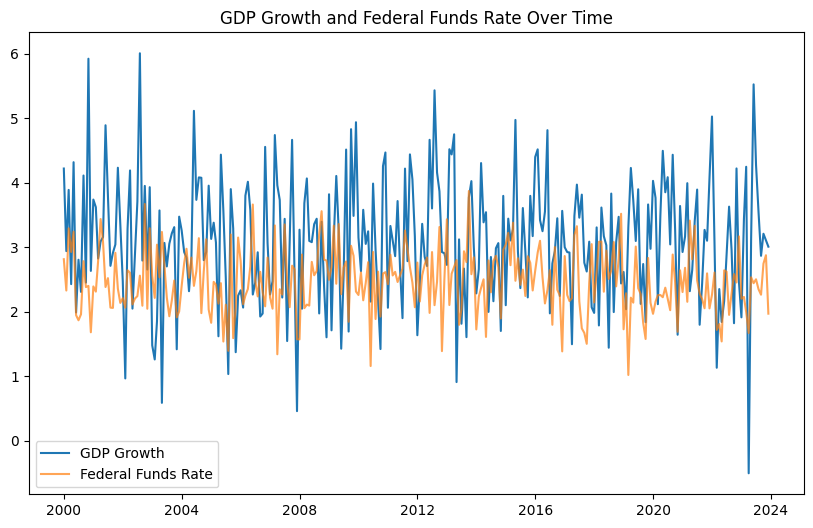

In [62]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['GDP Growth'], label='GDP Growth')
plt.plot(data.index, data['Federal Funds Rate'], label='Federal Funds Rate', alpha=0.7)
plt.legend()
plt.title('GDP Growth and Federal Funds Rate Over Time')
plt.show()

In [72]:
# Now month to month percentage changes
# identify first yield curve inversion dates
# VAR model too

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [73]:
def simulate_data(N):
    start_date = '2000-01-01'
    end_date = '2023-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    N = len(dates)

    mean = [2.5, 5.0, 0.2, 20, 100, 100, 3]
    cov = np.array([
        [0.25, 0.05, 0, 0.1, 0.1, 0.1, 0.1],
        [0.05, 1, 0, 0.05, 0.1, 0.1, 0.05],
        [0, 0, 0.04, 0, 0, 0, 0],
        [0.1, 0.05, 0, 5, 0.5, 0.5, 0.1],
        [0.1, 0.1, 0, 0.5, 10, 1, 0.2],
        [0.1, 0.1, 0, 0.5, 1, 10, 0.2],
        [0.1, 0.05, 0, 0.1, 0.2, 0.2, 1]
    ])
    cov = (cov + cov.T) / 2

    data = np.random.multivariate_normal(mean, cov, N)
    df = pd.DataFrame(data, columns=['Federal Funds Rate', 'Unemployment Rate', 'Yield Curve Inversion',
                                     'VIX', 'BCI', 'CCI', 'GDP Growth'], index=dates)
    df['Yield Curve Inversion'] = (df['Yield Curve Inversion'] > 0.5).astype(int)
    return df


In [74]:
def calculate_monthly_changes(data):
    for col in ['VIX', 'BCI', 'CCI', 'GDP Growth']:
        data[col + ' % Change'] = data[col].pct_change() * 100
    return data

def identify_first_inversions(data):
    data['First YC Inversion'] = (data['Yield Curve Inversion'].diff() == 1).astype(int)
    data['12M First YC Inversion'] = data['First YC Inversion'].rolling(window=12, min_periods=1).max()
    return data


In [75]:
def fit_var_model(data, lags=12):
    model = VAR(data[['GDP Growth % Change', 'VIX % Change', 'BCI % Change', 'CCI % Change', '12M First YC Inversion']])
    results = model.fit(maxlags=lags, ic='aic')
    print(results.summary())
    return results

def plot_transformed_data(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['GDP Growth % Change'], label='GDP Growth % Change')
    plt.plot(data.index, data['VIX % Change'], label='VIX % Change', alpha=0.7)
    plt.legend()
    plt.title('Month/Month % Change in GDP Growth and VIX')
    plt.show()


In [76]:
# RUN THIS CELL TO RUN THE OTHER FUNCTIONS SEQUENTIALLY
data = simulate_data(288)
data = calculate_monthly_changes(data)
data = identify_first_inversions(data)
var_results = fit_var_model(data)
plot_transformed_data(data)


LinAlgError: SVD did not converge in Linear Least Squares